In [1]:
import numpy as np
import os
import pandas as pd
import sys

# Config

In [2]:
HYPER_OPT = True 
HYPER_OPT_TIME = 8*60*60
USE_ORIGINAL_DATA = False 
SUBMIT_TO_KAGGLE = False
COMPUTE_NONLOG = False
USE_NONLOG = False

In [3]:
# Define the base directory (where the notebook is running)
base_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Define the data directory
data_dir = os.path.join(base_dir, "data")

model_dir = os.path.join(base_dir, "models")

notebooks_dir = os.path.join(base_dir, "notebooks")

sys.path.append(base_dir)

# Data Extraction

In [4]:
from axyom_utilities.data_extraction import extract_data
from axyom_utilities.training import train_model_cv
from axyom_utilities.wrappers import CatBoostRegressorWrapper
from axyom_utilities.preprocessing import * 
from toolz import pipe
import joblib

def get_oof(X_train, y_train, X_test):
    
    #X_train, y_train, X_test, X_orig, y_orig = extract_data(data_dir, USE_ORIGINAL_DATA, log_transform=False) # IMPORTANT: no log transform

    preprocessor = lambda df: pipe(df,\
        preprocess_dates,
        all_to_string    
    )

    X_train = preprocessor(X_train)
    X_test = preprocessor(X_test)
    
    params = {
        "iterations":500,
        "learning_rate":0.1,
        "depth":6,
        "eval_metric":"RMSE",
        "random_seed":42,
        "verbose":200,
        "task_type":'GPU',
        "l2_leaf_reg" :0.7,
    }
    
    results = train_model_cv(
        model=CatBoostRegressorWrapper(**params),
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        early_stopping_rounds=100,
        cv_splits=5
    )
    
    oof, test = results["oof_preds"], results['test_preds']
    
    joblib.dump((oof, test), "nonlog_feature/nonlog.pkl")
    
    return oof, test



# oof_log = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\oof_preds_log.csv"))
# oof_nonlog = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\oof_preds_nonlog.csv"))

# test_log = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\test_preds_log.csv"))
# test_nonlog = pd.read_csv(os.path.join(notebooks_dir, "Catboost_nonlog\\test_preds_nonlog.csv"))

# X_train["oof_nonlog"] = oof_nonlog + np.random.normal(0, 0.01, oof_log.shape) # noise
# X_test["oof_nonlog"] = test_nonlog + np.random.normal(0, 0.01, oof_log.shape)

# X_test["oof_log"] = test_log
# X_train["oof_log"] = oof_log

In [5]:
X_train, y_train, X_test, X_orig, y_orig = extract_data(data_dir, USE_ORIGINAL_DATA, log_transform=True)
y_train_nonlog = np.expm1(y_train)

if USE_NONLOG:
    if COMPUTE_NONLOG:
        nonlog_oof_preds, nonlog_test_preds = get_oof(X_train, y_train_nonlog, X_test)
    else:
        nonlog_oof_preds, nonlog_test_preds = joblib.load('nonlog_feature/cat_non_loged.pkl')
    
    X_train["nonlog"] = nonlog_oof_preds
    X_test["nonlog"] = nonlog_test_preds

# Data Cleaning

In [6]:
from axyom_utilities.preprocessing import freq_encode, preprocess_dates, clean_categorical, frequency_encode
from toolz import pipe

def feature_engineering(df):
    
    # df = freq_encode(df)
    
    df['MissingHealth'] = df['Health Score'].isna().astype(int)
    df['Claims v Duration'] = df['Previous Claims'] / df['Insurance Duration']
    df['Health vs Claims'] = df['Health Score'] / df['Previous Claims']
    
    def duplicate_int(col, df):
        df[col + ' Integer'] = df[col].apply(lambda x: int(x) if pd.notna(x) else x)
        df[col] = df[col].fillna('None').astype('string')
        
        return df
    
    df = duplicate_int('Health Score', df)
    df = duplicate_int('Credit Score', df)
    df = duplicate_int('Previous Claims', df)
    df = duplicate_int('Annual Income', df)
    
    df['MissingValuesCount'] = df.isna().sum(axis=1)
    
    # df = freq_encode(df, 'Customer Feedback')
    # df = freq_encode(df, 'Marital Status')
    
    return df

preprocessor = lambda df: pipe(df,\
    preprocess_dates,
    clean_categorical,
    feature_engineering,  
)

X_train = preprocessor(X_train)
X_test = preprocessor(X_test)
if USE_ORIGINAL_DATA:
    X_orig = preprocessor(X_orig)
    
frequency_encode(X_train, X_test, drop_org=False) # data leaking but acceptable in this context


(          Age  Gender Annual Income Marital Status  Number of Dependents  \
 id                                                                         
 0        19.0  Female       10049.0        Married                   1.0   
 1        39.0  Female       31678.0       Divorced                   3.0   
 2        23.0    Male       25602.0       Divorced                   3.0   
 3        21.0    Male      141855.0        Married                   2.0   
 4        21.0    Male       39651.0         Single                   1.0   
 ...       ...     ...           ...            ...                   ...   
 1199995  36.0  Female       27316.0        Married                   0.0   
 1199996  54.0    Male       35786.0       Divorced                   NaN   
 1199997  19.0    Male       51884.0       Divorced                   0.0   
 1199998  55.0    Male          None         Single                   1.0   
 1199999  21.0  Female          None       Divorced                   0.0   

In [7]:
# features_ranked = [
#     "Annual Income Integer",
#     "Credit Score Integer",
#     "Health Score",
#     "Credit Score",
#     "Health Score Integer",
#     "Health Score_freq",
#     "Annual Income_freq",
#     "Annual Income",
#     "DaysSinceStart",
#     "Previous Claims",
#     "Customer Feedback",
#     "Credit Score_freq",
#     "Age",
#     "Vehicle Age",
#     "Marital Status",
#     "Week",
#     "Number of Dependents",
#     "Insurance Duration",
#     "Exercise Frequency",
#     "Day",
#     "Occupation",
#     "Property Type",
#     "Health vs Claims",
#     "Education Level",
#     "DayCos",
#     "Location",
#     "MissingHealth",
#     "Claims v Duration",
#     "Previous Claims_freq",
#     "Policy Type",
#     "DaySin",
#     "Customer Feedback_freq",
#     "WeekdaySin",
#     "Previous Claims Integer",
#     "Occupation_freq",
#     "Weekday",
#     "Month",
#     "WeekdayCos",
#     "Exercise Frequency_freq",
#     "Education Level_freq",
#     "Marital Status_freq",
#     "Policy Type_freq",
#     "Location_freq",
#     "MissingValuesCount",
#     "Property Type_freq",
#     "Gender",
#     "Smoking Status_freq",
#     "Smoking Status",
#     "Gender_freq"
# ]

# N = len(features_ranked) - 20

# columns = features_ranked[:N]

# X_train = X_train[columns]

# X_test = X_test[columns]

# HyperOpt

[I 2024-12-23 02:37:34,922] A new study created in RDB with name: Catboost Reduced Features V2


Training fold 1...
Fold 1 RMSE: 1.0347
Training fold 2...
Fold 2 RMSE: 1.0340
Training fold 3...
Fold 3 RMSE: 1.0329
Training fold 4...
Fold 4 RMSE: 1.0351
Training fold 5...


[I 2024-12-23 02:47:50,367] Trial 0 finished with value: 1.0341163522240842 and parameters: {'learning_rate': 0.05433350003437882, 'depth': 14, 'l2_leaf_reg': 2.4130797751196207, 'bagging_temperature': 2.9114322289922994, 'border_count': 245, 'random_strength': 0.001124120293579448, 'min_data_in_leaf': 42}. Best is trial 0 with value: 1.0341163522240842.


Fold 5 RMSE: 1.0339
Mean CV RMSE: 1.0341 ± 0.0007
Training fold 1...
Fold 1 RMSE: 1.0373
Training fold 2...
Fold 2 RMSE: 1.0363
Training fold 3...
Fold 3 RMSE: 1.0354
Training fold 4...
Fold 4 RMSE: 1.0377
Training fold 5...


[I 2024-12-23 03:51:48,947] Trial 1 finished with value: 1.0365494694824255 and parameters: {'learning_rate': 0.0013210376916733295, 'depth': 5, 'l2_leaf_reg': 0.347001641179058, 'bagging_temperature': 0.8009901573379099, 'border_count': 198, 'random_strength': 0.005909735070200815, 'min_data_in_leaf': 71}. Best is trial 0 with value: 1.0341163522240842.


Fold 5 RMSE: 1.0361
Mean CV RMSE: 1.0365 ± 0.0008
Training fold 1...
Fold 1 RMSE: 1.0321
Training fold 2...
Fold 2 RMSE: 1.0314
Training fold 3...
Fold 3 RMSE: 1.0305
Training fold 4...
Fold 4 RMSE: 1.0324
Training fold 5...


[I 2024-12-23 05:17:01,577] Trial 2 finished with value: 1.0316101988998994 and parameters: {'learning_rate': 0.005325514524961518, 'depth': 14, 'l2_leaf_reg': 0.0010605818577217204, 'bagging_temperature': 0.45143061452683186, 'border_count': 56, 'random_strength': 0.00978752568525981, 'min_data_in_leaf': 3}. Best is trial 2 with value: 1.0316101988998994.


Fold 5 RMSE: 1.0316
Mean CV RMSE: 1.0316 ± 0.0007
Training fold 1...
Fold 1 RMSE: 1.0354
Training fold 2...
Fold 2 RMSE: 1.0350
Training fold 3...
Fold 3 RMSE: 1.0339
Training fold 4...
Fold 4 RMSE: 1.0362
Training fold 5...


[I 2024-12-23 05:30:52,384] Trial 3 finished with value: 1.0351332400796207 and parameters: {'learning_rate': 0.0633377585550492, 'depth': 8, 'l2_leaf_reg': 0.009716632605151102, 'bagging_temperature': 3.6367183713583504, 'border_count': 251, 'random_strength': 0.13527270558543472, 'min_data_in_leaf': 26}. Best is trial 2 with value: 1.0316101988998994.


Fold 5 RMSE: 1.0351
Mean CV RMSE: 1.0351 ± 0.0007
Training fold 1...
Fold 1 RMSE: 1.0330
Training fold 2...
Fold 2 RMSE: 1.0324
Training fold 3...
Fold 3 RMSE: 1.0312
Training fold 4...
Fold 4 RMSE: 1.0336
Training fold 5...


[I 2024-12-23 06:06:27,687] Trial 4 finished with value: 1.0324993268133027 and parameters: {'learning_rate': 0.027936670586075445, 'depth': 8, 'l2_leaf_reg': 27.82893387677385, 'bagging_temperature': 2.5056181070257, 'border_count': 215, 'random_strength': 0.15466130896990424, 'min_data_in_leaf': 42}. Best is trial 2 with value: 1.0316101988998994.


Fold 5 RMSE: 1.0324
Mean CV RMSE: 1.0325 ± 0.0008
Training fold 1...
Fold 1 RMSE: 1.0349
Training fold 2...
Fold 2 RMSE: 1.0340
Training fold 3...
Fold 3 RMSE: 1.0335
Training fold 4...
Fold 4 RMSE: 1.0356
Training fold 5...


[I 2024-12-23 06:20:15,278] Trial 5 finished with value: 1.0344999419378702 and parameters: {'learning_rate': 0.06928161326365447, 'depth': 8, 'l2_leaf_reg': 0.002375924958606164, 'bagging_temperature': 3.1007719138086536, 'border_count': 81, 'random_strength': 0.00207667486958039, 'min_data_in_leaf': 49}. Best is trial 2 with value: 1.0316101988998994.


Fold 5 RMSE: 1.0344
Mean CV RMSE: 1.0345 ± 0.0007
Training fold 1...
Fold 1 RMSE: 1.0318
Training fold 2...
Fold 2 RMSE: 1.0311
Training fold 3...
Fold 3 RMSE: 1.0298
Training fold 4...
Fold 4 RMSE: 1.0320
Training fold 5...
Fold 5 RMSE: 1.0314
Mean CV RMSE: 1.0312 ± 0.0008


[I 2024-12-23 10:40:32,962] Trial 6 finished with value: 1.031200281883863 and parameters: {'learning_rate': 0.0024025303850357584, 'depth': 14, 'l2_leaf_reg': 0.009054048982222585, 'bagging_temperature': 1.0816358150014032, 'border_count': 157, 'random_strength': 4.069317345142579, 'min_data_in_leaf': 86}. Best is trial 6 with value: 1.031200281883863.
c:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:59: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  plot_optimization_history(self.study)


Best Trial:  {'learning_rate': 0.0024025303850357584, 'depth': 14, 'l2_leaf_reg': 0.009054048982222585, 'bagging_temperature': 1.0816358150014032, 'border_count': 157, 'random_strength': 4.069317345142579, 'min_data_in_leaf': 86}
Best Score:  1.031200281883863


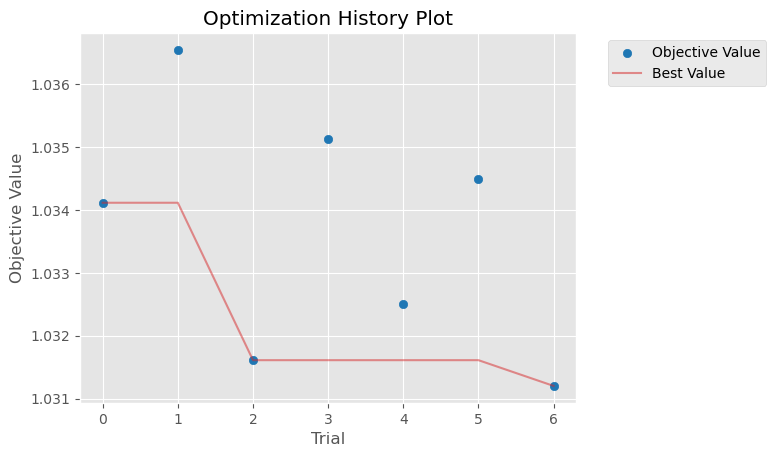

c:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:62: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  plot_param_importances(self.study)


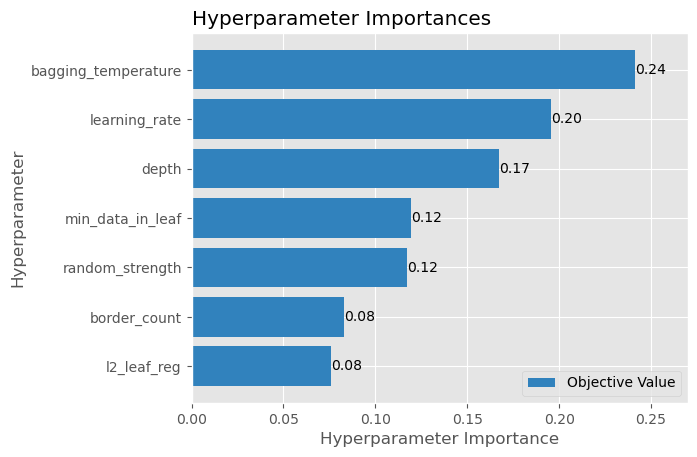

c:\Users\Axyom\Kaggle\PG S4e12 - Regression Insurance\axyom_utilities\hyperparameter_tuning.py:65: ExperimentalWarning: plot_slice is experimental (supported from v2.2.0). The interface can change in the future.
  plot_slice(self.study)


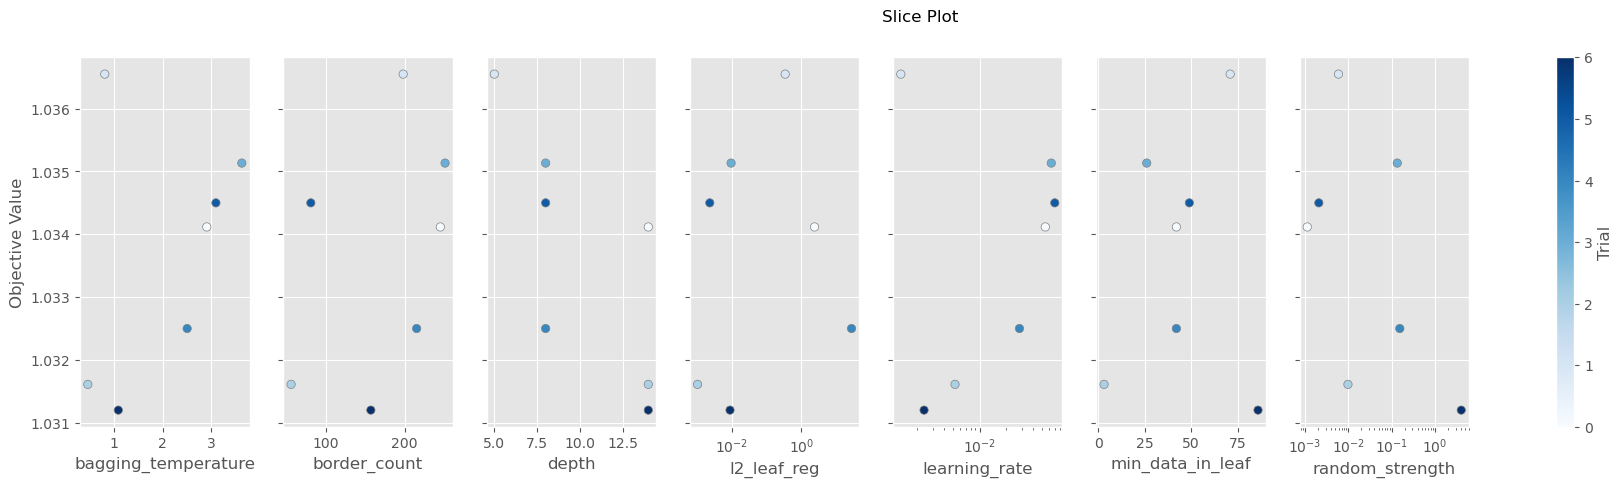

In [8]:
from axyom_utilities.hyperparameter_tuning import CatBoostTuner

if HYPER_OPT:
    catboost_tuner = CatBoostTuner(X_train, y_train, HYPER_OPT_TIME, study_name=None)
    best_params = catboost_tuner.tune()
    catboost_tuner.plot()
else:
    best_params = {
        "iterations": 5883,
        "task_type": "GPU",
        "verbose": False,
        "learning_rate": 0.00521765446243734,
        "depth": 11,
        "l2_leaf_reg": 0.020973837119135495,
        "bagging_temperature": 0.12952601761069596,
        "border_count": 136,
        "random_strength": 6.979958130250014,
        "min_data_in_leaf": 1
    }

In [9]:
best_params

{'iterations': 7315,
 'task_type': 'GPU',
 'verbose': False,
 'learning_rate': 0.0024025303850357584,
 'depth': 14,
 'l2_leaf_reg': 0.009054048982222585,
 'bagging_temperature': 1.0816358150014032,
 'border_count': 157,
 'random_strength': 4.069317345142579,
 'min_data_in_leaf': 86}

In [10]:
best_params["iterations"] = 10000

# Model Training

In [11]:
import json

model = CatBoostRegressorWrapper(**best_params)

# Use the train_model function to train and evaluate the model
results = train_model_cv(
    model=model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    X_orig=X_orig,
    early_stopping_rounds=100,
    cv_splits=5
)

Training fold 1...


KeyboardInterrupt: 

In [12]:
# from sklearn import mean_squared_log_error

# def rmsle(y_true, y_pred):
#     return np.sqrt(mean_squared_log_error(y_true, y_pred))

# rmsle_score = rmsle(y_train, results["oof_preds"])

# print(f"RMSLE score = {rmsle_score}")

In [ ]:
models = results['models']

# Get feature importance
feature_importances = models[3].catboost_model_.get_feature_importance(type='PredictionValuesChange')

# Map to feature names
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                    Feature  Importance
33    Annual Income Integer   15.035999
31     Credit Score Integer    8.780135
7              Health Score    8.296790
12             Credit Score    5.498149
30     Health Score Integer    5.378875
40        Health Score_freq    4.669488
36       Annual Income_freq    4.274421
2             Annual Income    4.095164
26           DaysSinceStart    4.084965
10          Previous Claims    4.024697
14        Customer Feedback    2.578604
44        Credit Score_freq    2.277013
0                       Age    1.986682
11              Vehicle Age    1.607041
3            Marital Status    1.405289
20                     Week    1.322552
4      Number of Dependents    1.321311
13       Insurance Duration    1.302202
16       Exercise Frequency    1.251517
19                      Day    1.192000
6                Occupation    1.171781
17            Property Type    1.128039
29         Health vs Claims    1.109188
5           Education Level    1.092786


In [14]:
mean_score = np.mean(results["cv_scores"])
std_score = np.std(results["cv_scores"])

# Saving

In [15]:
import joblib
import json
from pathlib import Path

results_dir = Path(f"{mean_score:.4f}+-{std_score:.4f}")
os.makedirs(results_dir, exist_ok=True)

# Save OOF predictions as a CSV file
oof_preds_df = pd.DataFrame({"oof_preds": results["oof_preds"]})
oof_preds_df.to_csv(results_dir/"oof_preds.csv", index=False)

test_preds_df = pd.DataFrame({"test_preds": results["test_preds"]})
test_preds_df.to_csv(results_dir/"test_preds.csv", index=False)

with open(results_dir/"best_params", "w") as f:
    json.dump(best_params, f, indent=4)

#joblib.dump(results["models"], "models.pkl")

# Submission

In [16]:
y_pred = np.expm1(results['test_preds'])

submission = pd.DataFrame({
    'id': X_test.index,  
    'Premium Amount': y_pred
})

FILE_PATH = os.path.join(results_dir, f"Catboost_{mean_score:.4f}+-{std_score:.4f}.csv")

submission.to_csv(FILE_PATH, index=False)

In [17]:
if False: 
    # Define your message and file paths
    COMP_NAME = "playground-series-s4e12"

    SUBMIT_MESSAGE = "Catboost_{mean_score:.4f}+-{std_score:.4f}"

    # Submit to Kaggle
    os.system(f'kaggle competitions submit -c {COMP_NAME} -f {FILE_PATH} -m "{SUBMIT_MESSAGE}"')